In [1]:
## . . Import the plotting and libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import *

## . . For animation
from matplotlib import animation
from IPython.display import HTML, Image

<h1><center>LAB 4 - Solving Elliptical PDEs for Steady-state Solutions</center></h1>


## NAME: Ethan Deal $\hspace{2.5in}$                                 STUDENT NUMBER: 10878509

The purpose of this lab is to get you thinking about solving 2D elliptical PDEs for steady-state problems.  In the first part, you will validate your code by comparing the generated numerical solution against the known analytic version. You will then generate numerical solutions for two scenarios where no analytic solution exists.

**Note: GPGN536 students will use C to reproduce the python codes in the notebook for the computational part.

## Part 1 - Validating Against a Known Solution

You are given a 2D rectanglar region with dimensions of $0\le x \le a$ and $0\le y \le b$ and are looking to compute the interior temperature profile $T(x,y)$. The four sides of the rectangle are held at the following **constant** temperatures:

$$T(x=0,y) = T_1 \tag{1a}$$
$$T(x=a,y) = 0   \tag{1b}$$
$$T(x,y=0) = 0   \tag{1c}$$
$$T(x,y=b) = T_2 \tag{1d}$$

What is the steady-state temperature profile $T(x,y)$ for this system?

Fortunately, you are also given the following theoretical solution to this problem:

$$T(x,y) = \frac{4}{\pi}
\left(
T_2
\sum_{m=0}^{\infty}
\frac{\sin \frac{\pi(2m+1)x}{a}}{2m+1}\frac{\sinh \frac{\pi(2m+1)y}{a}}{\sinh \frac{\pi(2m+1)b}{a}}
+
T_1
\sum_{m=0}^{\infty}
\frac{\sin \frac{\pi(2m+1)y}{b}}{2m+1}\frac{\sinh \frac{\pi(2m+1)(a-x)}{b}}{\sinh \frac{\pi(2m+1)a}{b}}
\right).
\tag{2}
$$

**Q1-1**: Choose a discrete 2D domain on which you will generate numerical solutions. This will require choosing values for dimensions $a$ and $b$.  Note that it is good coding practice to not hard code these values into your solution, but to leave them as variables that can be changed for different geometries. However, without loss of generality, for this problem let's assume that $a=b=1$ for simplicity.

Having chosen your numerical domain, set $T_1 = -1$ and $T_2 = 1$ and then generate a plot of the **analytic** solution given in equation 2. Note that this solution includes two infinite sums. In practice, though, you should only need to sum a finite number of terms. Aim for a value of $m=M$ after which the solution does not change by more than $0.001\%$.

Note that there is a discrepancy of what to do in the corners. For simulation purposes, set the four corner points equal to 0.


In [2]:
# written with the help of ChatGPT, analytic solution function
def T(x, y, a, b, T1, T2):
    # Create a 2D meshgrid for x and y
    X, Y = np.meshgrid(x, y)

    # Initialize the result and previous result arrays
    result = np.zeros_like(X)
    prev_result = np.copy(result)

    m = 0
    while True:
        # First summation terms
        term1_x = np.sin(np.pi * (2*m + 1) * X / a) / (2*m + 1)
        term2_y = np.sinh(np.pi * (2*m + 1) * Y / a) / np.sinh(np.pi * (2*m + 1) * b / a)
        result += T2 * term1_x * term2_y

        # Second summation terms
        term1_y = np.sin(np.pi * (2*m + 1) * Y / b) / (2*m + 1)
        term2_x = np.sinh(np.pi * (2*m + 1) * (a - X) / b) / np.sinh(np.pi * (2*m + 1) * a / b)
        result += T1 * term1_y * term2_x

        # Multiply by the constant factor
        result *= 4 / np.pi

        # Check for convergence
        diff_norm = np.mean((abs(result - prev_result)))/np.mean(abs(result))
        if diff_norm < 0.00001 * np.mean(abs(result)):
            break

        prev_result = np.copy(result)
        m += 1

    # normalize result
    result = result/np.max(result)

    result = result.T

    # Apply boundary conditions
    result[:, 0] = 0
    result[:, -1] = T2
    result[0, :] = T1
    result[-1, :] = 0

    result[0,0] = 0
    result[0,-1] = 0
    result[-1,0] = 0
    result[-1,-1] = 0


    return result, m

In [3]:
# define parameters
T1=-1
T2=1
xmin,xmax,ymin,ymax=0,1,0,1
nx,ny=50, 50
xx = np.linspace(xmin,xmax,nx)
yy = np.linspace(ymin,ymax,ny)

# solve PDE using analytic method
tr,M = T(xx, yy, xmax, ymax, T1, T2)

print('After', M, 'iterations, the solution is achieved with less than 0.001% difference')

After 47 iterations, the solution is achieved with less than 0.001% difference


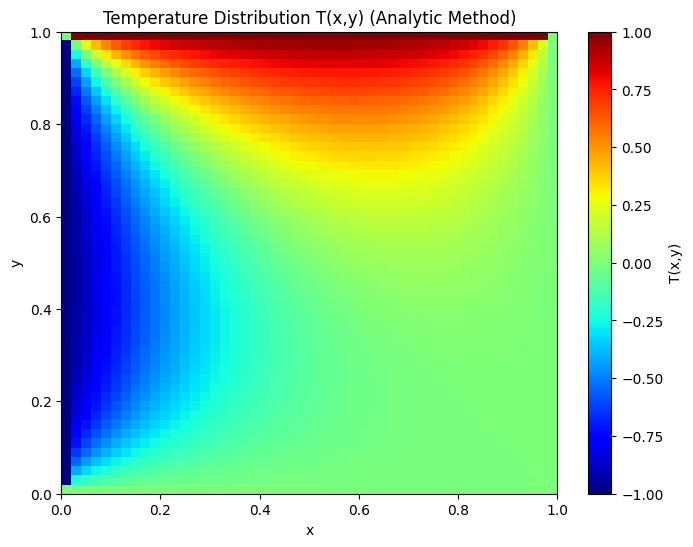

In [4]:
# plot results
plt.figure(figsize=(8, 6))
plt.imshow(tr.T, origin='lower', extent=[0, xmax, 0, ymax], aspect='auto', cmap='jet')
plt.colorbar(label='T(x,y)')
plt.title('Temperature Distribution T(x,y) (Analytic Method)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**Q1-2:** Generate your 2D numerical solution for this problem using the approach developed in the course notebook. To illustrate your numerical solution, develop an animation showing (1) the analytic solution, (2) the numerical solution at the current solution step, and (3) the difference between the analytic and numerical solutions at the current solution step.  This should be similar to Figure 4 in the notes.  


In [5]:
# define tridiagonal matrix creating function
def Setup_Tridiagonal(a,b,c,n):
    '''Set up regular tridiagonal matrix
    usage: x = Gauss_elimination(A,b,print_process=False):
    input:
        a: value along -1 subdiagonal
        b: value along main diagonal
        c: value along +1 supediagonal
        n: dimension of NxN matrix
    output:
        A: tridiagonal matrix with Dirichlet boundary condition
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    A = np.diag(a*np.ones(n-1),-1)+np.diag(b*np.ones(n),0)+np.diag(c*np.ones(n-1),1)
    A[0,0] = 1
    A[0,1] = 0
    A[-1,-1] = 1
    A[-1,-2] = 0
    return A

In [6]:
# define ADI solution function
def ADI_Solution(U):
    '''Set up Alternating Direction Solution of Laplace's Equation
    usage: U = ADI_Solution(U)
    input:
        U: starting field
    output:
        U: solution updated in both directions
    dependencies:
        Setup_Tridiagonal
        np.linalg.solve
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    modified by Ge Jin, gjin@mines.edu, 09/2022
    '''
    ## . . Array dimensions from the input file
    nx,ny = np.size(U,0),np.size(U,1)

    ## . . Allocated dummy array to be used as a temporary solution
    U1 = np.zeros((nx,ny))

    ## . . Force boundary conditions
    U1[:   ,0] = U[:   ,0]
    U1[0   ,:] = U[0   ,:]
    U1[:,ny-1] = U[:,ny-1]
    U1[nx-1,:] = U[nx-1,:]

    ## . . Define tridiagonal matrix in X
    Ax = Setup_Tridiagonal(1, -4, 1, nx)
    bx = np.zeros((nx))

    ## . . Define tridiagonal matrix in Y
    Ay = Setup_Tridiagonal(1, -4, 1, ny)
    by = np.zeros((ny))

    ## . . STEP 1 (solve in the x direction and loop over j - y)
    ## . . Note that we're writing the results to temporary array U1
    for jj in range(1,ny-1):
        bx = -U[:,jj-1]-U[:,jj+1]
        # apply boundary condition
        bx[0] = U[0,jj]
        bx[-1] = U[-1,jj]
        U1[:,jj] = np.linalg.solve(Ax,bx)

    ## . . STEP 2 (solve in the x direction and loop over j - y)
    ## . . Note that we're now rewriting the updated result back to U
    for ii in range(1,nx-1):
        by = -U1[ii-1,:]-U1[ii+1,:]
        # apply boundary condition
        by[0] = U1[ii,0]
        by[-1] = U1[ii,-1]
        U[ii,:] = np.linalg.solve(Ay,by)


    ## . . Return the U solution array after a complete cycle of x and y updating!
    return U

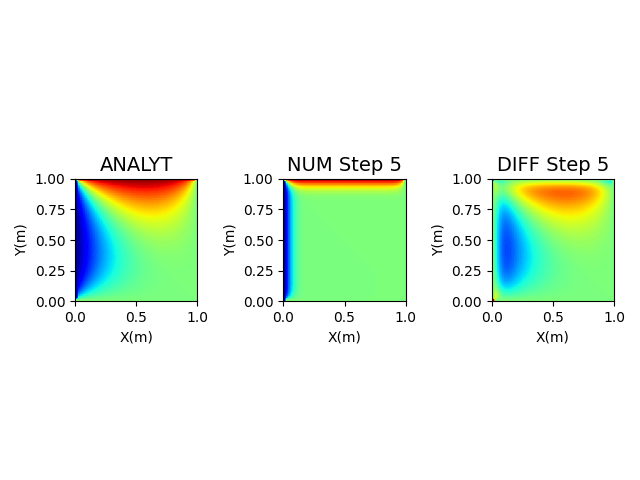

In [7]:
nt = 100 # number of iterations
h = xx[1]-xx[0] # discretization

## . . Initialize
U0 = np.zeros((nx,ny))

## . . Boundary Conditions
U0[:,0] = 0
U0[0,:] = T1
U0[:,ny-1] = T2
U0[nx-1,:] = 0

# . . Plotting min/max
vmin,vmax = np.min(tr),np.max(tr)

## . . Movie solution
c = np.zeros((nx,ny,nt))

## . . Call Solution
for i in range(nt):
    c[:,:,i]=U0
    value = ADI_Solution(U0)
    U0 = value

# . . Compute error
err = np.zeros((nt))
for ii in range(nt):
    x = c[:,:,ii]
    err[ii] = np.linalg.norm(tr-x)

# . . Normalize error
err=err/err[0]

## . . Animate Solution
k = 0
kskip=5

## . . Set up movie
fig,ax = plt.subplots(1,3)
fig.subplots_adjust(0,0,1,1)
fig.set_dpi(100)

def Laplace_animate(i):
    global k
    x = c[:,:,k]
    ax[0].imshow(tr.T,cmap='jet', origin='lower', extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[0].set(xlabel='X(m)', ylabel='Y(m)')
    ax[0].set_title('ANALYT',fontsize=14)
    ax[1].imshow(x.T ,cmap='jet', origin='lower', extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[1].set(xlabel='X(m)', ylabel='Y(m)')
    ax[1].set_title('NUM Step %s'%k,fontsize=14)
    ax[2].imshow((tr-x).T ,cmap='jet', origin='lower', extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[2].set(xlabel='X(m)', ylabel='Y(m)')
    ax[2].set_title('DIFF Step %s'%k,fontsize=14)
    k += kskip
    plt.tight_layout()

## . . Call the animator
ani_filename = 'Ex1.gif'
anim1 = animation.FuncAnimation(fig,
                            Laplace_animate,
                            frames=int((nt-2*kskip)/kskip),
                            interval=100)
anim1.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

**Q1-3:** Since we know the analytic solution, we can calculate a **convergence plot** illustrating how the error in the numerical solution decreases with the number of solution steps. Do so in the space provided below. This should be similar to Figure 5 in the notes.


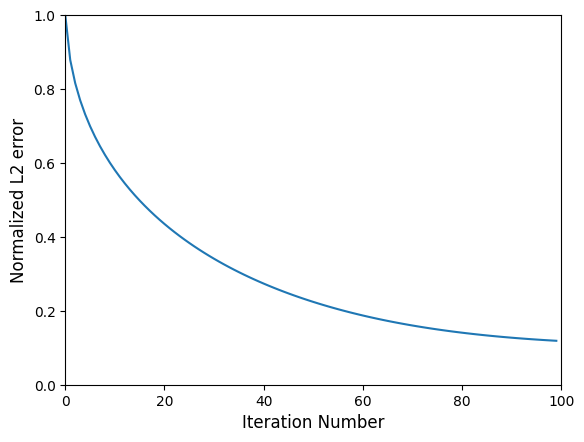

In [8]:
## . . Plot error over iterations
fig2 = plt.figure()
plt.plot(range(nt),err)
plt.ylim(0,1)
plt.xlim(0,nt)
plt.xlabel('Iteration Number',fontsize=12),plt.ylabel('Normalized L2 error',fontsize=12)
plt.show()

**Q1-4:** An important question is **how does the choice of discretization $\Delta xR$ and $\Delta y$ affect the accuracy and convergence rate of the numerical solution**?  Illustrate the difference by redoing the questions **Q1-2** and **Q1-3** above using **double** the number of grid points in both the $x$ and $y$ directions.  Produce one figure illustrating your numerical solution like you did in **Q1-2** and a second figure comparing the convergence rates for your original and modified spatial sampling like in **Q1-3**.

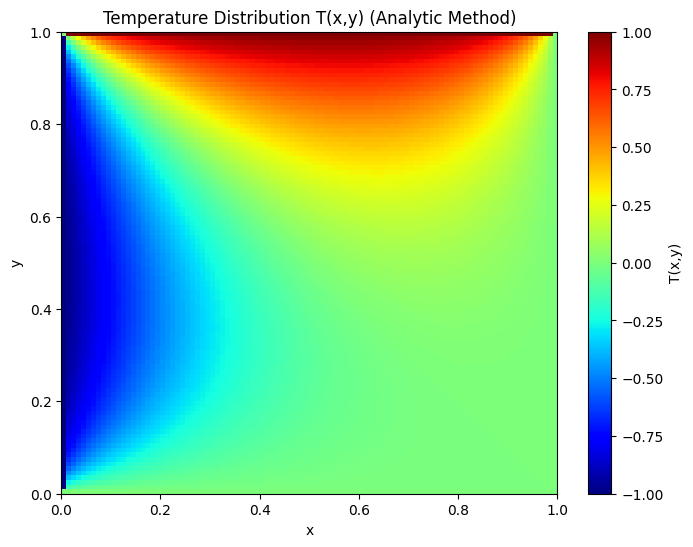

In [9]:
# define parameters
nx,ny=100, 100
xx = np.linspace(xmin,xmax,nx)
yy = np.linspace(ymin,ymax,ny)

# solve PDE using analytic method
tr,M = T(xx, yy, xmax, ymax, T1, T2)

# plot results
plt.figure(figsize=(8, 6))
plt.imshow(tr.T, origin='lower', extent=[0, xmax, 0, ymax], aspect='auto', cmap='jet')
plt.colorbar(label='T(x,y)')
plt.title('Temperature Distribution T(x,y) (Analytic Method)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**As expected, the analytic solution with double the number of gridpoints is much smoother.**

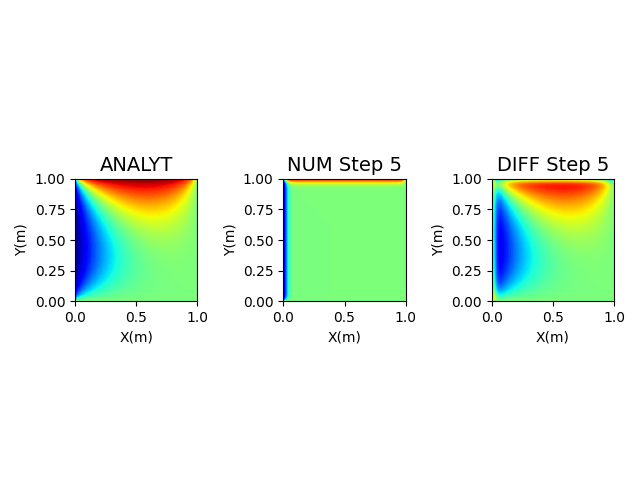

In [10]:
nt = 100 # number of iterations
h = xx[1]-xx[0]

## . . Initialize
U0 = np.zeros((nx,ny))

## . . Boundary Conditions
U0[:,0] = 0
U0[0,:] = T1
U0[:,ny-1] = T2
U0[nx-1,:] = 0


# . . Plotting min/max
vmin,vmax = np.min(tr),np.max(tr)

## . . Movie solution
c = np.zeros((nx,ny,nt))

## . . Call Solution
for i in range(nt):
    c[:,:,i]=U0
    value = ADI_Solution(U0)
    U0 = value

# . . Compute error
err = np.zeros((nt))
for ii in range(nt):
    x = c[:,:,ii]
    err[ii] = np.linalg.norm(tr-x)

# . . Normalize error
err=err/err[0]

## . . Animate Solution
k = 0
kskip=5

## . . Set up movie
fig,ax = plt.subplots(1,3)
fig.subplots_adjust(0,0,1,1)
fig.set_dpi(100)

def Laplace_animate(i):
    global k
    x = c[:,:,k]
    ax[0].imshow(tr.T,cmap='jet', origin='lower', extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[0].set(xlabel='X(m)', ylabel='Y(m)')
    ax[0].set_title('ANALYT',fontsize=14)
    ax[1].imshow(x.T ,cmap='jet', origin='lower', extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[1].set(xlabel='X(m)', ylabel='Y(m)')
    ax[1].set_title('NUM Step %s'%k,fontsize=14)
    ax[2].imshow((tr-x).T ,cmap='jet', origin='lower', extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[2].set(xlabel='X(m)', ylabel='Y(m)')
    ax[2].set_title('DIFF Step %s'%k,fontsize=14)
    k += kskip
    plt.tight_layout()

## . . Call the animator
ani_filename = 'Ex1.gif'
anim1 = animation.FuncAnimation(fig,
                            Laplace_animate,
                            frames=int((nt-2*kskip)/kskip),
                            interval=100)
anim1.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

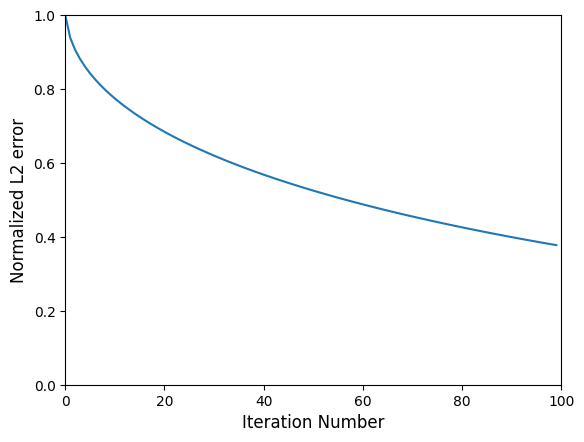

In [11]:
## . . Plot error over iterations
fig2 = plt.figure()
plt.plot(range(nt),err)
plt.ylim(0,1)
plt.xlim(0,nt)
plt.xlabel('Iteration Number',fontsize=12),plt.ylabel('Normalized L2 error',fontsize=12)
plt.show()

**The normalized L2 error starts at 1 for both. However, for the solution with more gridpoints, the error is about 0.4 after 100 iterations, while it is only 0.2 for the other after 100 iterations.**

## Part 2 - Adding in a heat source

Let's now add some complexity to the physical scenario in Part 1 above.  Let's keep the same experimental set up; however, now we have decided to add a heater element at location $[x,y]=[a/2,b/2]$ (again where $a=b=1$) that outputs heat at constant temperature flux of $2T_2$ per unit area. Also, the size of the heat source is 0.1x0.1. This situation can be modeled solving by Poisson's equation:

$$
\nabla^2 T = 2T_2 \hspace{2cm} \text{for grids inside heat source}
\begin{cases}
    2T_2 & \text{if inside heat source}  \\
    0 & \text{if outside heat source}
\end{cases}
\tag{3}
$$

**Q2-1:** Provide an illustration (i.e., animation or series of plots) showing how including this heat source affects the final steady-state solution.  (Note that there is no analytic solution for this problem against which to compare your solution.)


In [12]:
# define ADI solution function for heat source
def ADI_Solution_Forcing(U,h,F):
    '''Set up Alternating Direction Solution of Poisson Equation
    usage: U = ADI_Solution(U,h,F)
    input:
        U: starting field
        h: sample interval
        F: Forcing Field
    output:
        U: solution updated in both directions
    dependencies:
        Setup_Tridiagonal
        np.linalg.solve
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    ## . . Array dimensions from the input file
    nx,ny = np.size(U,0),np.size(U,1)

    ## . . Allocated dummy array to be used as a temporary solution
    U1 = np.zeros((nx,ny))

    ## . . Force boundary conditions
    U1[:   ,0] = U[:   ,0]
    U1[0   ,:] = U[0   ,:]
    U1[:,ny-1] = U[:,ny-1]
    U1[nx-1,:] = U[nx-1,:]

    ## . . Define tridiagonal matrix in X
    Ax = Setup_Tridiagonal(1, -4, 1, nx)
    bx = np.zeros((nx))

    ## . . Define tridiagonal matrix in Y
    Ay = Setup_Tridiagonal(1, -4, 1, ny)
    by = np.zeros((ny))

    ## . . STEP 1 (solve in the x direction and loop over j - y)
    ## . . Note that we're writing the results to temporary array U1
    for jj in range(1,ny-1):
        bx = -h*h*F[:,jj]-U[:,jj-1]-U[:,jj+1]
        # apply boundary condition
        bx[0] = U[0,jj]
        bx[-1] = U[-1,jj]
        U1[:,jj] = np.linalg.solve(Ax,bx)


    ## . . STEP 2 (solve in the x direction and loop over j - y)
    ## . . Note that we're now rewriting the updated result back to U
    for ii in range(1,nx-1):
        by = -h*h*F[ii,:]-U1[ii-1,:]-U1[ii+1,:]
        # apply boundary condition
        by[0] = U1[ii,0]
        by[-1] = U1[ii,-1]
        U[ii,:] = np.linalg.solve(Ay,by)

    return U

In [13]:
# define gridding parameters
xmin,xmax,ymin,ymax=0,1,0,1
nx,ny=100, 100
xx = np.linspace(xmin,xmax,nx)
yy = np.linspace(ymin,ymax,ny)
h = xx[1] - xx[0]

# define index bounds of heat source
i1 = int(0.45 / h)
i2 = int(0.55 / h)

## . . Initialize
U0 = np.zeros((nx,ny))

## . . Boundary Conditions
U0[:,0] = 0
U0[nx-1,:] = 0
U0[0,:] = T1
U0[:,ny-1] = T2


## . . Set up forcing term
## Because of the delta function, the integral of force term over space should
## equals to F
FF = np.zeros((nx,ny))
FF[i1:i2,i1:i2] = 200 * T2

# . . Plotting min/max
vmin,vmax = 0,1

## . . Movie solution
e = np.zeros((nx,ny,nt))
conv = np.zeros((nt)) # . . For convergence

## . . Call Solution
for i in range(nt):
    e[:,:,i]=U0
    value = ADI_Solution_Forcing(U0,h,FF)
    U0 = value
    conv[i] = np.linalg.norm(e[:,:,i]-U0)  ## . . Let's examine the convergence
conv=conv/conv[0] ## . . Normalize

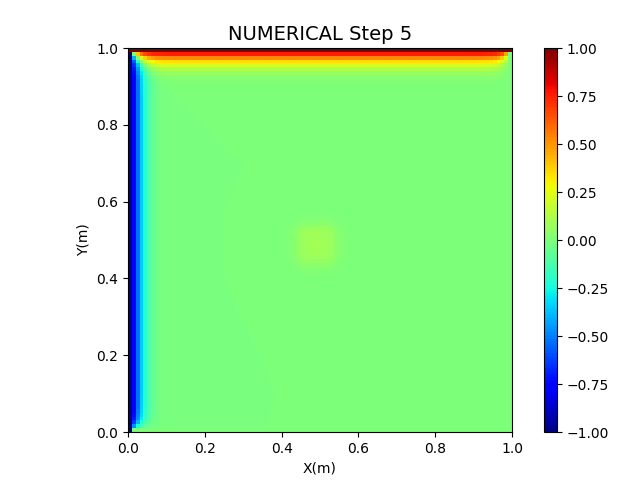

In [14]:
## . . Animate Solution and compute error
k = 0
kskip=5
## . . Set up movie
fig3,ax3 = plt.subplots()
fig3.subplots_adjust(0.1,0.1,0.9,0.9)
fig3.set_dpi(100)

x = e[:,:,k]
const_K = x.T
imax = ax3.imshow(x,cmap='jet',extent=[xmin,xmax,ymin,ymax])
cbar_ax = fig3.add_axes([0.85,0.1,0.02,0.8])
# fig3.colorbar(imax,ax=cbar_ax)

def Poisson_animate(i):
    global k
    x = e[:,:,k]
    cbar_ax.cla()
    imax = ax3.imshow(x.T,cmap='jet', origin='lower',extent=[xmin,xmax,ymin,ymax])
    ax3.set(xlabel='X(m)', ylabel='Y(m)')
    ax3.set_title('NUMERICAL Step %s'%k,fontsize=14)
    fig3.colorbar(imax,cax=cbar_ax)
    k += kskip

## . . Call the animator
ani_filename = 'Ex2.gif'
anim2 = animation.FuncAnimation(fig3,Poisson_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim2.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

**Q2-2:** Add a plot showing the convergence similar to that shown in Figure 7 of the notebook.

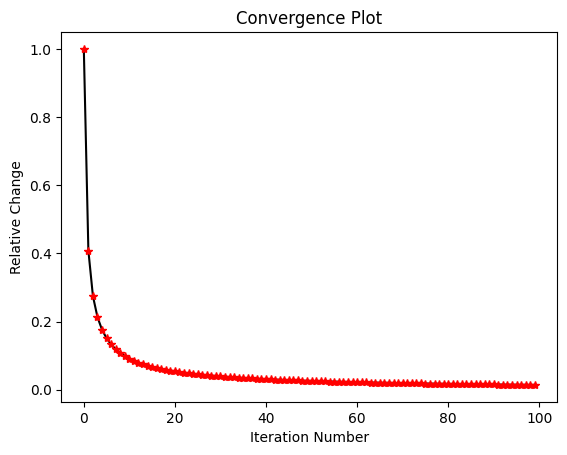

In [15]:
# plot convergence
plt.figure()
plt.plot(range(nt),conv,'k',range(nt),conv,'r*')
plt.xlabel('Iteration Number'); plt.ylabel('Relative Change')
plt.title('Convergence Plot')
plt.show()

## Part 3 - Adding in Spatially Varying Thermal Conductivity

You now have a situation where the medium inside the rectangle has a thermal conductivity $K(x,y)$ is given by:

$$K(x,y) = 1-0.75 {\rm e}^{- \left(x-\frac{a}{2}\right)^2-\left(y-\frac{b}{2}\right)^2} \tag{4}$$

**Q3-1:** Extend the example from Part 2 (i.e., with the heat source) to include the above spatially varying thermal conductivity.  This will require solving the following elliptical PDE:

$$\nabla \cdot \left(K \nabla T\right) = 2T_2 \delta\left(x-\frac{a}{2},y-\frac{b}{2}\right).\tag{5}$$

Provide an illustration (i.e., animation or series of plots) showing how the inclusion of both the spatially varying thermal conductivity and heat source terms affect the final steady-state solution.


In [16]:
# define function to setup tridiagonal matrix for heterogeneous k
def Setup_Tridiagonal_Heterogeneous(a,b,c,n):
    '''Set up regular tridiagonal matrix
    usage: x = Gauss_elimination(A,b,print_process=False):
    input:
        a: values along -1 diagonal (n-1 vector length)
        b: values along 0  diagonal (n   vector length)
        c: values along +1 diagonal (n-1 vector length)
        n: dimension of NxN matrix
    output:
        A: tridiagonal matrix with Dirichlet Boundary Condition
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    A = np.diag(a, -1) + np.diag(b, 0) + np.diag(c, 1)
    A[0,0] = 1
    A[0,1] = 0
    A[-1,-1] = 1
    A[-1,-2] = 0
    return A

In [17]:
# define ADI solution for heterogeneous K, and heat source
def ADI_Solution_Heterogeneous(U,K, F, h):
    '''Set up Alternating Direction Solution of Laplace Equation in Heterogeneous media
    usage: U = ADI_Solution(U,K)
    input:
        U: starting field
        K: Heterogenerous Diffusion field (function of x and y)
    output:
        U: solution updated in both directions
    dependencies:
        F: Forcing function
        h: sample interval
        Setup_Tridiagonal
        np.linalg.solve
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    nx,ny = np.size(U,0),np.size(U,1)
    U1    = np.zeros((nx,ny))

    ## . . Force boundary conditions
    U1[:   ,0] = U[:   ,0]
    U1[0   ,:] = U[0   ,:]
    U1[:,ny-1] = U[:,ny-1]
    U1[nx-1,:] = U[nx-1,:]

    ## . . Coefficients for x
    axmat = np.zeros((nx-1))
    bxmat = np.zeros((nx  ))
    cxmat = np.zeros((nx-1))
    bx    = np.zeros((nx  ))

    ## . . Coefficients for y
    aymat = np.zeros((ny-1))
    bymat = np.zeros((ny  ))
    cymat = np.zeros((ny-1))
    by    = np.zeros((ny  ))


    ## . . Loop over j (y)
    for jj in range(1,ny-1):

        axmat = K[0:nx-1,jj]
        bxmat = -2.*K[:,jj]-K[:,jj-1]-np.insert(K[0:nx-1,jj],0,0)
        cxmat = K[1:nx  ,jj]

        ## . . have to set this up each time b/c is heterogeneous now
        Ax = Setup_Tridiagonal_Heterogeneous(axmat,bxmat,cxmat,nx)
        bx = -h*h*F[:,jj]-np.multiply(K[:,jj],U[:,jj+1]) - np.multiply(K[:,jj-1],U[:,jj-1])

        # force boundary condition
        bx[0] = U[0,jj]
        bx[-1] = U[-1,jj]

        U1[:,jj] = np.linalg.solve(Ax,bx)


    ## . . Loop over i (x)
    for ii in range(1,nx-1):
        aymat =     K[ii,0:ny-1]
        bymat = -2.*K[ii,:     ]-K[ii-1,:]-np.insert(K[ii,0:ny-1],0,0)
        cymat =     K[ii,1:ny  ]

        ## . . have to set this up each time b/c is heterogeneous now
        Ay = Setup_Tridiagonal_Heterogeneous(aymat,bymat,cymat,ny)
        by = -h*h*F[ii,:]-np.multiply(K[ii,:],U1[ii+1,:]) - np.multiply(K[ii-1,:],U1[ii-1,:])

        by[0] = U1[ii,0]
        by[-1] = U1[ii,-1]

        U[ii,:] = np.linalg.solve(Ay,by)

    return U

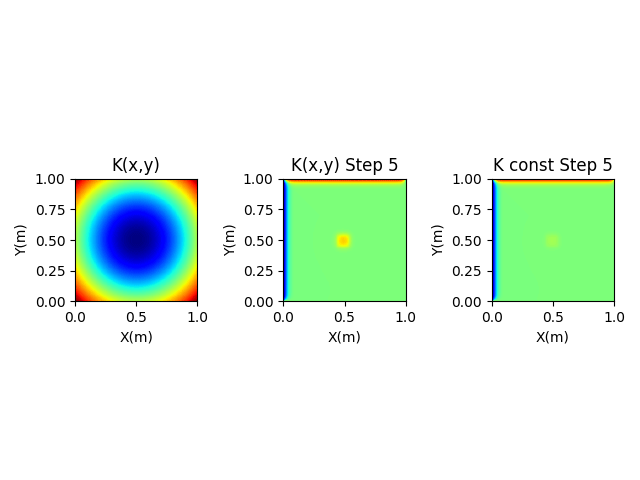

In [18]:
## . . Space axis parameters
nt = 100 # number of iterations
xmin,xmax,ymin,ymax=0,1,0,1
nx,ny=100,100
xx = np.linspace(xmin,xmax,nx)
yy = np.linspace(ymin,ymax,ny)
h = xx[1]-xx[0]
a,b=1,1

## . . Initialize
U0 = np.zeros((nx,ny))

## . . Boundary Conditions
U0[:,0] = 0
U0[nx-1,:] = 0
U0[0,:] = T1
U0[:,ny-1] = T2

## . . Set up forcing term
## Because of the delta function, the integral of force term over space should
## equals to F
FF = np.zeros((nx,ny))
FF[i1:i2,i1:i2] = 200 * T2

# . . Plotting min/max
vmin,vmax = np.min(U0),np.max(U0)

## . . Heterogeneous solution
xxx, yyy = np.meshgrid(xx, yy, sparse=True)
K = np.zeros((nx,ny))+1 - 0.75*np.exp((-(xxx-a/2)**2-(yyy-b/2)**2))
Kmin,Kmax = np.min(K),np.max(K)

## . . Movie solution
f = np.zeros((nx,ny,nt))

## . . Call Solution
for i in range(nt):
    f[:,:,i]=U0
    value = ADI_Solution_Heterogeneous(U0,K,FF,h)
    U0 = value

## . . Animate Solution and compute error
k = 0
kskip = 5

## . . Set up movie
fig4,ax4 = plt.subplots(1,3)
fig4.subplots_adjust(0,0,1,1)
fig4.set_dpi(100)

def Laplace_heterogeneous_animate(i):
    global k
    x = f[:,:,k]
    y = e[:,:,k]
    ax4[0].imshow(K.T,cmap='jet', origin = 'lower', extent=[xmin,xmax,ymin,ymax],vmin=Kmin,vmax=Kmax)
    ax4[0].set(xlabel='X(m)', ylabel='Y(m)')
    ax4[0].set_title('K(x,y)',fontsize=12)
    ax4[1].imshow(x.T ,cmap='jet', origin = 'lower',extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax4[1].set(xlabel='X(m)', ylabel='Y(m)')
    ax4[1].set_title('K(x,y) Step %s'%k,fontsize=12)
    ax4[2].imshow(y.T ,cmap='jet',origin = 'lower',extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax4[2].set(xlabel='X(m)', ylabel='Y(m)')
    ax4[2].set_title('K const Step %s'%k,fontsize=12)
    k += kskip
    plt.tight_layout()

## . . Call the animator
ani_filename = 'Ex3.gif'
anim4 = animation.FuncAnimation(fig4,Laplace_heterogeneous_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim4.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())